# DSCI - Project 01
## Analysis of NASA Server Logs
**Malcolm Nichols**

## Part A: Set up Environment
in this part we will use import statements to set up the environment

In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

Next cell will create our SparkSession and SparkContext objects

In [0]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Part B: Load and Process Data
This part will consist of parsing through a file that contains server log data from NASA. We will begin by
loading in the file into an RDD and printing the number of elements.

In [0]:
nasa_raw = sc.textFile('/FileStore/tables/NASA_server_logs_Aug_1995.txt')
print(nasa_raw.count())

1569888

We will now display the first few elements of the RDD nasa_raw

In [0]:
for row in nasa_raw.take(10):
    print(row)

in24.inetnebr.com [01/Aug/1995:00:00:01] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt" 200 1839
uplherc.upl.com [01/Aug/1995:00:00:07] "GET /" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/ksclogo-medium.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/MOSAIC-logosmall.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/USA-logosmall.gif" 304 0
ix-esc-ca2-07.ix.netcom.com [01/Aug/1995:00:00:09] "GET /images/launch-logo.gif" 200 1713
uplherc.upl.com [01/Aug/1995:00:00:10] "GET /images/WORLD-logosmall.gif" 304 0
slppp6.intermind.net [01/Aug/1995:00:00:10] "GET /history/skylab/skylab.html" 200 1687
piweba4y.prodigy.com [01/Aug/1995:00:00:10] "GET /images/launchmedium.gif" 200 11853
slppp6.intermind.net [01/Aug/1995:00:00:11] "GET /history/skylab/skylab-small.gif" 200 9202

We will now process each line via tokenizing, removing quotes, replacing hyphens and coercing values into appropriate datatypes

In [0]:
def process_row(row):
    tokens = row.replace('"', '').split(' ')
    
    if tokens[-1] == '-':
        tokens[-1] = '0'
        
    if len(tokens) != 6:
        return row
    
    tokens[-1] = int(tokens[-1])
    
    return tokens

nasa = nasa_raw.map(process_row)
nasa.persist() 
for row in nasa.take(10):
    print(row)


['in24.inetnebr.com', '[01/Aug/1995:00:00:01]', 'GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', '200', 1839]
['uplherc.upl.com', '[01/Aug/1995:00:00:07]', 'GET', '/', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/ksclogo-medium.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/MOSAIC-logosmall.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/USA-logosmall.gif', '304', 0]
['ix-esc-ca2-07.ix.netcom.com', '[01/Aug/1995:00:00:09]', 'GET', '/images/launch-logo.gif', '200', 1713]
['uplherc.upl.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/WORLD-logosmall.gif', '304', 0]
['slppp6.intermind.net', '[01/Aug/1995:00:00:10]', 'GET', '/history/skylab/skylab.html', '200', 1687]
['piweba4y.prodigy.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/launchmedium.gif', '200', 11853]
['slppp6.intermind.net', '[01/Aug/1995:00:00:11]', 'GET', '/history/skylab/skylab-small.gif', '200', 9202]

## Part C: Most Requested Resources
We will check to see which resources were requested the most frequestly

In [0]:
count_by_resource = (
    nasa
    .map(lambda x: (x[3], 1))
    .reduceByKey(lambda x, y : x + y)
    .sortBy(lambda x: x[1], ascending=False )
)

for row in count_by_resource.take(10):             
    print(row)


('/images/NASA-logosmall.gif', 97410)
('/images/KSC-logosmall.gif', 75337)
('/images/MOSAIC-logosmall.gif', 67448)
('/images/USA-logosmall.gif', 67068)
('/images/WORLD-logosmall.gif', 66444)
('/images/ksclogo-medium.gif', 62778)
('/ksc.html', 43688)
('/history/apollo/images/apollo-logo1.gif', 37826)
('/images/launch-logo.gif', 35138)
('/', 30347)

## Part D: Most Common Request Origins
This part will determine which servers are the origins for the greatest number of requests

In [0]:
count_by_origin = (
    nasa
    .map(lambda x : (x[0], 1))
    .reduceByKey(lambda x, y : x + y)
    .sortBy(lambda x : x[1], ascending=False)
)

for row in count_by_origin.take(10):
    print(row)

('edams.ksc.nasa.gov', 6530)
('piweba4y.prodigy.com', 4846)
('163.206.89.4', 4791)
('piweba5y.prodigy.com', 4607)
('piweba3y.prodigy.com', 4416)
('www-d1.proxy.aol.com', 3889)
('www-b2.proxy.aol.com', 3534)
('www-b3.proxy.aol.com', 3463)
('www-c5.proxy.aol.com', 3423)
('www-b5.proxy.aol.com', 3411)

## Part E: Request Types
We will now analyze records based on their request type. We will start by confirming that there are three different reuqest types.

In [0]:
req_types = nasa.map(lambda x : x[2]).distinct().collect()
print(req_types)

['GET', 'HEAD', 'POST']

We will now count the number of requests for each type.

In [0]:
for ele in req_types:
    ele_count = nasa.filter(lambda x : ele in x).count()
    print(f'There were {ele_count:>10} {ele} requests.')

There were 1565812 GET requests.
There were 3965 HEAD requests.
There were 111 POST requests.

This cell will determine the average number of bytes returned to the client for each request type.

In [0]:
avg_bytes = (
    nasa
    .map(lambda x : (x[2], (x[-1], 1)))
    .reduceByKey(lambda x, y : (x[0] + y[0], x[1] + y[1]))
    .map(lambda x : (x[0], round(x[1][0] / x[1][1])))           # round to nearest integar, round() no argument will round up if >= 5 and down if < 5
)

for row in avg_bytes.collect():
    print(row)

('GET', 17134)
('HEAD', 0)
('POST', 495)

## Part F: Status Codes
In this part, we will analyze the status codes returned by the server

In [0]:
status_codes = (
    nasa
    .map(lambda x : x[4])
    .distinct()
    .sortBy(lambda x : x)
    .collect()
)

print(status_codes)

['200', '302', '304', '403', '404', '500', '501']

Next cell will show which status codes appear for each request type

In [0]:
for req_type in req_types:
    codes_to_type = (
        nasa
        .filter(lambda x : req_type in x)
        .map(lambda x : x[4])
        .distinct()
        .sortBy(lambda x : x)
        .collect()
    )
    
    if req_type == 'GET':
        print('Status codes for GET requests:  ', codes_to_type)
    if req_type == 'HEAD':
        print('Status codes for HEAD requests: ', codes_to_type)
    if req_type == 'POST':
        print('Status codes for POST requests: ', codes_to_type)

Status codes for GET requests: ['200', '302', '304', '403', '404', '500']
Status codes for HEAD requests: ['200', '302', '404']
Status codes for POST requests: ['200', '404', '501']

Now with each status code we will count the number of requests per status code

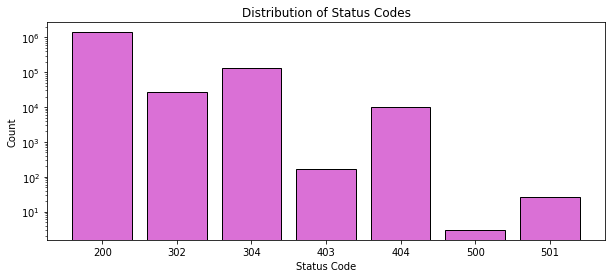

In [0]:
code_counts = []

for status_code in status_codes:
    code_counts.append(nasa.filter(lambda x : status_code in x).count())


plt.figure(figsize = [10, 4])
plt.bar(status_codes, code_counts, color = 'orchid', edgecolor = 'k')
plt.title('Distribution of Status Codes')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

## Part G: Request Volume by Day
In the final part of this project, we will be looking at and determining the number of requests recieved during each day in August 1995

In [0]:
counts_by_day = (
    nasa
    .map(lambda x : (x[1][1:3], 1))
    .reduceByKey(lambda x, y : x + y)
    .sortBy(lambda x : x)
    .collect()
)
print(counts_by_day[:5])                    # Both methods inclded to print out the list, the second will display on each line
# for tuples in counts_by_day[:5]:          # intructions did not say which method to use so I will use the first to show it in list form.
#     print(tuples)

[('01', 33996), ('03', 41388), ('04', 59557), ('05', 31893), ('06', 32420)]

We will now create a bar chart to display the distribution by the day of August 1995

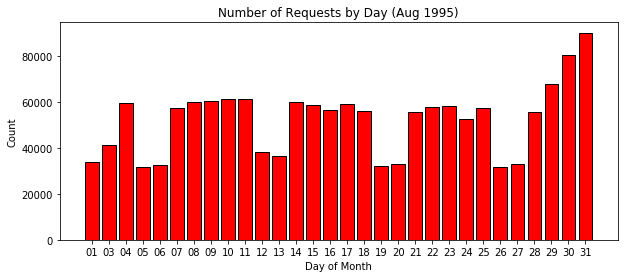

In [0]:
day_list = [day[0] for day in counts_by_day]
counts_list = [day[1] for day in counts_by_day]

plt.figure(figsize = [10,4])
plt.bar(day_list, counts_list, color = 'red', edgecolor = 'k')
plt.title('Number of Requests by Day (Aug 1995)')
plt.xlabel('Day of Month')
plt.ylabel('Count')
plt.show()